Dependencias PINNED + reinicio

In [ ]:
# ✅ Dependencias PINNED (compatibles con Colab) + reinicio del runtime
!pip -q install -U "numpy==1.26.4" "pandas==2.2.2" "scipy==1.11.4" "scikit-learn==1.4.2" \
                 "datasets==2.20.0" "transformers==4.44.2" "accelerate==0.33.0" \
                 "evaluate==0.4.2" "seaborn==0.13.2" "matplotlib==3.9.0" \
                 "openai==1.40.0"

import os, time
print("Reiniciando el runtime para aplicar dependencias…")
time.sleep(0.5)
os.kill(os.getpid(), 9)  # <- Fuerza el reinicio en Colab


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.8/35.8 MB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.1/315.1 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 360.4/360.4 kB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.

# === Imports y utils (re-ejecutar tras el reinicio) ===

In [ ]:

import os, sys, re, io, json, math, random, textwrap, itertools, csv, time, warnings
from pathlib import Path

import numpy as np, pandas as pd
from tqdm.auto import tqdm
warnings.filterwarnings("ignore")

SEED = 2025
random.seed(SEED); np.random.seed(SEED)

import seaborn as sns, matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score


##Clonar el repositorio solicitado

In [ ]:
# Clonar el repositorio solicitado (solo 1ª vez)
if not Path('EmoEvent').exists():
    !git clone -q https://github.com/fmplaza/EmoEvent.git

BASE = Path('EmoEvent/splits')
assert BASE.exists(), "No se encontró EmoEvent/splits. Revisa el git clone."
print("Subcarpetas:", [p.name for p in BASE.iterdir() if p.is_dir()])


Subcarpetas: ['es', 'en']


# Cargadores robustos de archivos (auto-detectan separador y columnas)



In [ ]:

def sniff_sep(fp: Path):
    sample = fp.read_bytes()[:4096].decode('utf-8', errors='ignore')
    try:
        dialect = csv.Sniffer().sniff(sample, delimiters=[',','\t',';','|'])
        return dialect.delimiter
    except Exception:
        return '\t' if '\t' in sample else ','

def find_cols(df: pd.DataFrame):
    cols = {c.lower(): c for c in df.columns}
    text_col  = next((cols[k] for k in ['text','tweet','content','sentence','texto'] if k in cols), None)
    label_col = next((cols[k] for k in ['label','labels','class','emocion','emotion'] if k in cols), None)
    event_col = next((cols[k] for k in ['event','evento','topic','event_id','id_event'] if k in cols), None)
    if text_col is None:  # fallback: la columna con textos más largos
        text_col = max(df.columns, key=lambda c: df[c].astype(str).str.len().mean())
    return text_col, label_col, event_col

def load_splits(lang='es'):
    lang_dir = BASE / lang
    assert lang_dir.exists(), f"No existe {lang_dir}"
    files = {'train': None, 'dev': None, 'test': None}
    for f in sorted(lang_dir.iterdir()):
        name = f.name.lower()
        for split in files:
            if name.startswith(split) and f.is_file():
                files[split] = f

    assert files['test'] is not None, f"Falta test* en {lang_dir}"
    assert files['train'] is not None, f"Falta train* en {lang_dir}"

    dfs = {}
    for k,fp in files.items():
        if fp is None:
            dfs[k] = None;
            continue
        sep = sniff_sep(fp)
        df  = pd.read_csv(fp, sep=sep, encoding='utf-8')
        tcol,lcol,ecol = find_cols(df)
        df = df.rename(columns={tcol:'text'})
        if lcol: df = df.rename(columns={lcol:'label'})
        if ecol: df = df.rename(columns={ecol:'event'})
        for c in ['text','label','event']:
            if c not in df.columns:
                df[c] = None
        dfs[k] = df[['text','label','event']].dropna(subset=['text','label']).reset_index(drop=True)
        print(f"[{lang}] {k}: {fp.name} -> {dfs[k].shape}")
    return dfs['train'], (dfs['dev'] if dfs['dev'] is not None else None), dfs['test']

train_es, dev_es, test_es = load_splits('es')
train_en, dev_en, test_en = load_splits('en')



[es] train: train.tsv -> (5723, 3)
[es] dev: dev.tsv -> (844, 3)
[es] test: test.tsv -> (1626, 3)
[en] train: train.tsv -> (5112, 3)
[en] dev: dev.tsv -> (744, 3)
[en] test: test.tsv -> (1447, 3)


# Normalización de etiquetas

In [ ]:

ALL_LABELS = ['anger','sadness','joy','disgust','fear','surprise','offensive','other']

def sanitize_labels(df: pd.DataFrame):
    df = df.copy()
    df['label'] = df['label'].astype(str).str.strip().str.lower()
    mapping = {'alegria':'joy','tristeza':'sadness','asco':'disgust','miedo':'fear',
               'sorpresa':'surprise','enojo':'anger','ofensivo':'offensive',
               'otros':'other','otro':'other'}
    df['label'] = df['label'].replace(mapping)
    df = df[df['label'].isin(ALL_LABELS)].reset_index(drop=True)
    return df

train_es = sanitize_labels(train_es); test_es  = sanitize_labels(test_es)
if dev_es is not None: dev_es = sanitize_labels(dev_es)

train_en = sanitize_labels(train_en); test_en  = sanitize_labels(test_en)
if dev_en is not None: dev_en = sanitize_labels(dev_en)

print(train_es['label'].value_counts().sort_index())
print(train_en['label'].value_counts().sort_index())


label
anger        589
disgust      111
fear          65
joy         1227
sadness      693
surprise     238
Name: count, dtype: int64
label
anger        274
disgust      536
fear         106
joy         1427
sadness      291
surprise     165
Name: count, dtype: int64


##Modelo 1 — SVM lineal con TF-IDF


### TF-IDF + LinearSVM (es)
              precision    recall  f1-score   support

       anger      0.254     0.265     0.260       166
     sadness      0.244     0.154     0.189       195
         joy      0.434     0.621     0.511       348
     disgust      1.000     0.030     0.059        33
        fear      0.000     0.000     0.000        21
    surprise      0.074     0.030     0.043        67
   offensive      0.000     0.000     0.000         0
       other      0.000     0.000     0.000         0

   micro avg      0.353     0.353     0.353       830
   macro avg      0.251     0.137     0.133       830
weighted avg      0.336     0.353     0.316       830



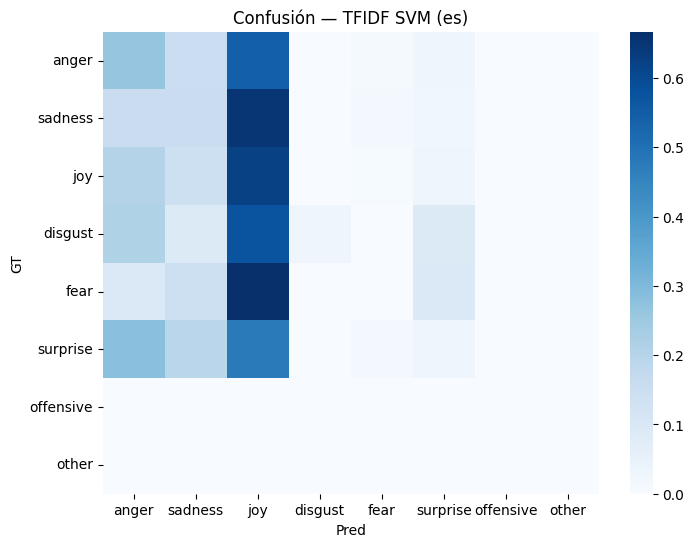


Top eventos por accuracy:
 event
LaLiga             0.500000
ChampionsLeague    0.428571
WorldBookDay       0.416000
GretaThunberg      0.352113
SpainElection      0.342342
GameOfThrones      0.286957
NotreDame          0.281553
Venezuela          0.254545
Name: ok, dtype: float64

### TF-IDF + LinearSVM (en)
              precision    recall  f1-score   support

       anger      0.410     0.205     0.274        78
     sadness      0.641     0.494     0.558        83
         joy      0.742     0.899     0.813       404
     disgust      0.465     0.576     0.515       151
        fear      0.333     0.067     0.111        30
    surprise      0.286     0.043     0.075        46
   offensive      0.000     0.000     0.000         0
       other      0.000     0.000     0.000         0

   micro avg      0.645     0.645     0.645       792
   macro avg      0.360     0.285     0.293       792
weighted avg      0.604     0.645     0.607       792



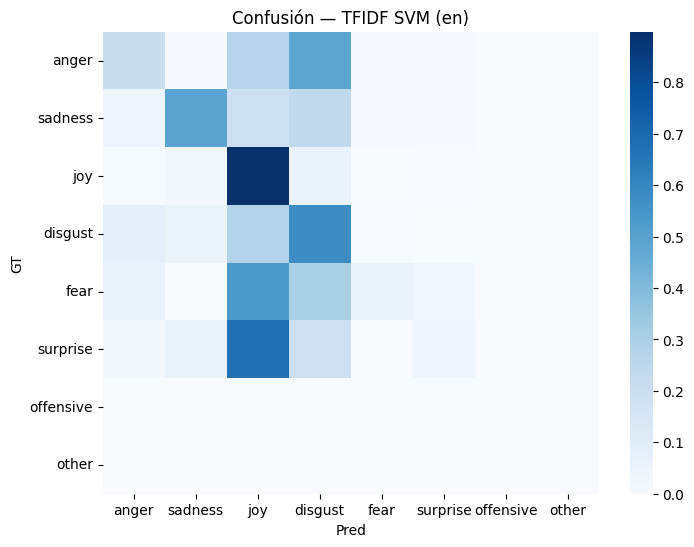


Top eventos por accuracy:
 event
WorldBookDay       0.911290
LaLiga             0.902439
GretaThunberg      0.666667
ChampionsLeague    0.661417
NotreDame          0.565789
GameOfThrones      0.562963
Venezuela          0.480916
SpainElection      0.400000
Name: ok, dtype: float64


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

def run_tfidf_svm(train_df, test_df, lang='es'):
    pipe = Pipeline([
        ('tfidf', TfidfVectorizer(
            sublinear_tf=True, lowercase=True,
            analyzer='word', ngram_range=(1,2), min_df=2, max_features=100_000
        )),
        ('clf', LinearSVC(C=1.0))
    ])
    pipe.fit(train_df['text'], train_df['label'])
    pred = pipe.predict(test_df['text'])

    print(f"\n### TF-IDF + LinearSVM ({lang})")
    rep = classification_report(test_df['label'], pred, labels=ALL_LABELS, digits=3, output_dict=True)
    print(classification_report(test_df['label'], pred, labels=ALL_LABELS, digits=3))
    cm = confusion_matrix(test_df['label'], pred, labels=ALL_LABELS, normalize='true')
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=ALL_LABELS, yticklabels=ALL_LABELS)
    plt.title(f'Confusión — TFIDF SVM ({lang})'); plt.xlabel('Pred'); plt.ylabel('GT'); plt.show()

    # por evento
    if 'event' in test_df.columns and test_df['event'].notna().any():
        ev = (test_df.assign(ok=(pred==test_df['label']))
                      .groupby('event')['ok'].mean().sort_values(ascending=False))
        print("\nTop eventos por accuracy:\n", ev.head(10))
    return pred, pipe, rep

pred_es_svm, svm_es, rep_es_svm = run_tfidf_svm(train_es, test_es, 'es')
pred_en_svm, svm_en, rep_en_svm = run_tfidf_svm(train_en, test_en, 'en')


# === Modelo 2 — XLM-RoBERTa (fine-tuning)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Map:   0%|          | 0/2923 [00:00<?, ? examples/s]

Map:   0%|          | 0/830 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,F1 Anger,F1 Sadness,F1 Joy,F1 Disgust,F1 Fear,F1 Surprise,F1 Offensive,F1 Other
1,1.051500,2.134338,0.375904,0.172894,0.282421,0.224138,0.530806,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.837500,2.461787,0.374699,0.170089,0.233010,0.229102,0.536199,0.000000,0.000000,0.022222,0.000000,0.000000
3,0.706300,2.688338,0.357831,0.181503,0.274854,0.229226,0.508015,0.000000,0.000000,0.076923,0.000000,0.000000



### XLM-RoBERTa (es) — test
eval_loss : 2.6883
eval_accuracy : 0.3578
eval_macro_f1 : 0.1815
eval_f1_anger : 0.2749
eval_f1_sadness : 0.2292
eval_f1_joy : 0.508
eval_f1_disgust : 0.0
eval_f1_fear : 0.0
eval_f1_surprise : 0.0769
eval_f1_offensive : 0.0
eval_f1_other : 0.0
eval_runtime : 1.9478
eval_samples_per_second : 426.116
eval_steps_per_second : 26.696


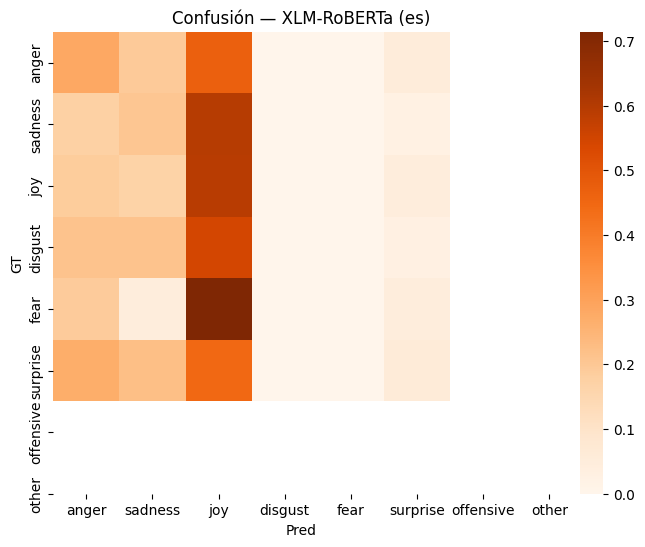


Top eventos por accuracy:
 event
LaLiga             0.451613
GretaThunberg      0.450704
SpainElection      0.405405
ChampionsLeague    0.375940
WorldBookDay       0.360000
Venezuela          0.327273
GameOfThrones      0.286957
NotreDame          0.271845
Name: ok, dtype: float64


Map:   0%|          | 0/2799 [00:00<?, ? examples/s]

Map:   0%|          | 0/792 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,F1 Anger,F1 Sadness,F1 Joy,F1 Disgust,F1 Fear,F1 Surprise,F1 Offensive,F1 Other
1,1.099900,0.990045,0.662879,0.329474,0.000000,0.552036,0.870098,0.554707,0.000000,0.000000,0.000000,0.000000
2,0.875500,0.888059,0.680556,0.360883,0.000000,0.666667,0.873096,0.582979,0.000000,0.042553,0.000000,0.000000
3,0.734100,0.857262,0.698232,0.375924,0.000000,0.663366,0.891358,0.597087,0.064516,0.039216,0.000000,0.000000



### XLM-RoBERTa (en) — test
eval_loss : 0.8573
eval_accuracy : 0.6982
eval_macro_f1 : 0.3759
eval_f1_anger : 0.0
eval_f1_sadness : 0.6634
eval_f1_joy : 0.8914
eval_f1_disgust : 0.5971
eval_f1_fear : 0.0645
eval_f1_surprise : 0.0392
eval_f1_offensive : 0.0
eval_f1_other : 0.0
eval_runtime : 1.7989
eval_samples_per_second : 440.273
eval_steps_per_second : 27.795


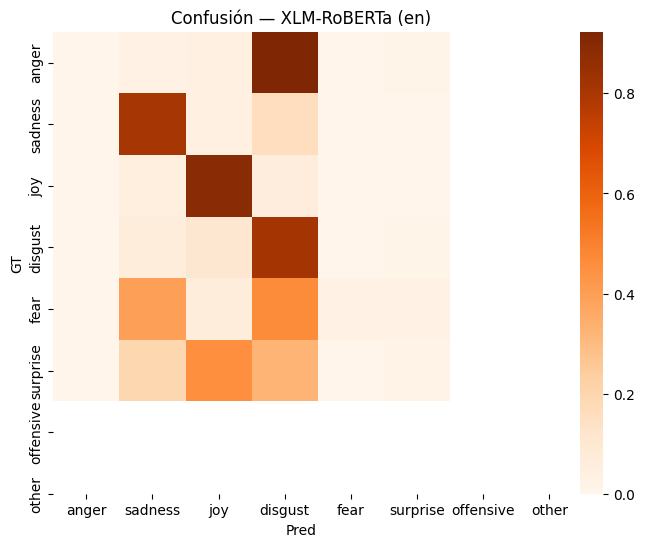


Top eventos por accuracy:
 event
LaLiga             0.975610
WorldBookDay       0.903226
GretaThunberg      0.708333
ChampionsLeague    0.685039
NotreDame          0.677632
GameOfThrones      0.651852
Venezuela          0.526718
SpainElection      0.300000
Name: ok, dtype: float64


In [ ]:

import torch, numpy as np
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

MODEL_NAME = "xlm-roberta-base"
EPOCHS, BATCH, LR = 3, 16, 2e-5  # ajusta si quieres

def enc_label(s):
    return ALL_LABELS.index(s)

def to_hf(df):
    return Dataset.from_dict({
        'text': df['text'].tolist(),
        'label': [enc_label(s) for s in df['label']],
        'event': df['event'].tolist()
    })

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize(batch):
    return tokenizer(batch['text'], truncation=True, padding='max_length', max_length=128)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    out = {
        "accuracy": accuracy_score(labels, preds),
        "macro_f1": f1_score(labels, preds, average='macro'),
    }
    # F1 por clase (mismo orden que ALL_LABELS):
    per_class = f1_score(labels, preds, average=None, labels=list(range(len(ALL_LABELS))))
    for i, lab in enumerate(ALL_LABELS):
        out[f"f1_{lab}"] = per_class[i]
    return out

def train_eval_transformer(train_df, test_df, lang='es'):
    ds_tr = to_hf(train_df).map(tokenize, batched=True)
    ds_te = to_hf(test_df).map(tokenize, batched=True)
    cols = ['input_ids','attention_mask','label']
    ds_tr.set_format(type='torch', columns=cols); ds_te.set_format(type='torch', columns=cols)

    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=len(ALL_LABELS))
    args = TrainingArguments(
        output_dir=f"./out_{lang}",
        per_device_train_batch_size=BATCH,
        per_device_eval_batch_size=BATCH,
        learning_rate=LR,
        num_train_epochs=EPOCHS,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="macro_f1",
        logging_steps=50,
        report_to="none",
        seed=2025,
        fp16=torch.cuda.is_available()
    )
    trainer = Trainer(model=model, args=args,
                      train_dataset=ds_tr, eval_dataset=ds_te,
                      tokenizer=tokenizer, compute_metrics=compute_metrics)
    trainer.train()
    metrics = trainer.evaluate(ds_te)
    print(f"\n### XLM-RoBERTa ({lang}) — test")
    for k,v in metrics.items():
        if k.startswith('eval_'):
            print(k, ":", round(v, 4))

    preds = np.argmax(trainer.predict(ds_te).predictions, axis=1)
    cm = confusion_matrix([enc_label(s) for s in test_df['label']], preds, normalize='true')
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=False, cmap='Oranges', xticklabels=ALL_LABELS, yticklabels=ALL_LABELS)
    plt.title(f'Confusión — XLM-RoBERTa ({lang})'); plt.xlabel('Pred'); plt.ylabel('GT'); plt.show()

    # análisis por evento
    if test_df['event'].notna().any():
        tmp = test_df.copy()
        tmp['pred'] = [ALL_LABELS[i] for i in preds]
        ev = (tmp.assign(ok=(tmp['pred']==tmp['label']))
                 .groupby('event')['ok'].mean().sort_values(ascending=False))
        print("\nTop eventos por accuracy:\n", ev.head(10))
    return trainer, metrics, preds

# Entrenar/Evaluar ES y EN
trainer_es, metrics_es, preds_es_xlmr = train_eval_transformer(train_es, test_es, 'es')
trainer_en, metrics_en, preds_en_xlmr = train_eval_transformer(train_en, test_en, 'en')


In [ ]:
# Desinstala los que fuerzan httpx 0.28.x (si no los usas aquí)
#Porque me daba problemas al gpt y con httpx y la solucion que encontre fue esta
!pip -q uninstall -y google-genai firebase-admin

# Deja versiones compatibles con el SDK de OpenAI v1.*
!pip -q install -U "openai==1.40.0" "httpx==0.27.2"

import httpx, pkg_resources, os, time
print("httpx:", httpx.__version__)
print("openai:", pkg_resources.get_distribution("openai").version)




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 4.3 MB/s eta 0:00:00
httpx: 0.27.2
openai: 1.40.0


##GPT-4o-mini (zero/few-shot con API de OpenAI)

In [ ]:

import os
from openai import OpenAI

OPENAI_API_KEY = "POR MOTIVOS DE PRIVACIDAD NO SUBO LA KEY"  # <- PON AQUÍ TU KEY
assert OPENAI_API_KEY.startswith(("sk-","sk-proj-")), "Coloca tu API key real (empieza con 'sk-' o 'sk-proj-')."


os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY
client = OpenAI(api_key=OPENAI_API_KEY)
print("Cliente OpenAI listo (no se imprimió la key).")

ALL_LABELS = ['anger','sadness','joy','disgust','fear','surprise','offensive','other']

SYSTEM_PROMPT = """You are an emotion classifier for Twitter/X posts.
Return only one label from this set: [anger, sadness, joy, disgust, fear, surprise, offensive, other].
If offensive content appears, prefer 'offensive' even if it also conveys an emotion.
Answer with just the label (lowercase)."""

FEWSHOT = [
    ("me hierve la sangre con este gobierno", "anger"),
    ("estoy muy triste por la noticia", "sadness"),
    ("qué asco de servicio", "disgust"),
    ("esto es una amenaza, tengo miedo", "fear"),
    ("jajaja no lo puedo creer", "surprise"),
    ("qué lindo día, soy feliz", "joy"),
    ("vete a ****", "offensive"),
    ("comparto información del evento", "other"),
]

# Normalización robusta de la salida del modelo
def normalize_label(text: str) -> str:
    t = text.strip().lower()
    # Coincidencia exacta primero
    if t in ALL_LABELS:
        return t
    # Buscar etiquetas como palabra completa
    for lab in ALL_LABELS:
        if re.search(rf"\b{re.escape(lab)}\b", t):
            return lab
    # Fallback prudente
    return "other"

def gpt_label(text, model="gpt-4o-mini", fewshot=True, max_retries=2):
    msgs = [{"role":"system","content": SYSTEM_PROMPT}]
    if fewshot:
        for t,y in FEWSHOT:
            msgs += [{"role":"user","content": f"Tweet:\n{t}\n\nLabel:"},
                     {"role":"assistant","content": y}]
    msgs += [{"role":"user","content": f"Tweet:\n{text}\n\nLabel:"}]

    last_err = None
    for _ in range(max_retries+1):
        try:
            r = client.chat.completions.create(
                model=model,
                messages=msgs,
                temperature=0,
            )
            out = r.choices[0].message.content
            return normalize_label(out)
        except Exception as e:
            last_err = e
            time.sleep(1.0)
    raise last_err


Cliente OpenAI listo (no se imprimió la key).


#Comprobacion

In [ ]:
print("joy?      ->", gpt_label("qué alegría, por fin ganamos!!"))
print("fear?     ->", gpt_label("no puedo creer lo que pasó, tengo miedo"))
print("offensive?->", gpt_label("eres un **** inútil"))


joy?      -> joy
fear?     -> fear
offensive?-> offensive


#Configuracion

GPT gpt-4o-mini:   0%|          | 0/400 [00:00<?, ?it/s]


### Reporte por clase
              precision    recall  f1-score   support

       anger      0.182     0.079     0.110        76
     sadness      0.286     0.103     0.152        97
         joy      0.446     0.218     0.292       170
     disgust      0.000     0.000     0.000        15
        fear      0.100     0.083     0.091        12
    surprise      0.200     0.067     0.100        30
   offensive      0.000     0.000     0.000         0
       other      0.000     0.000     0.000         0

    accuracy                          0.140       400
   macro avg      0.152     0.069     0.093       400
weighted avg      0.311     0.140     0.192       400



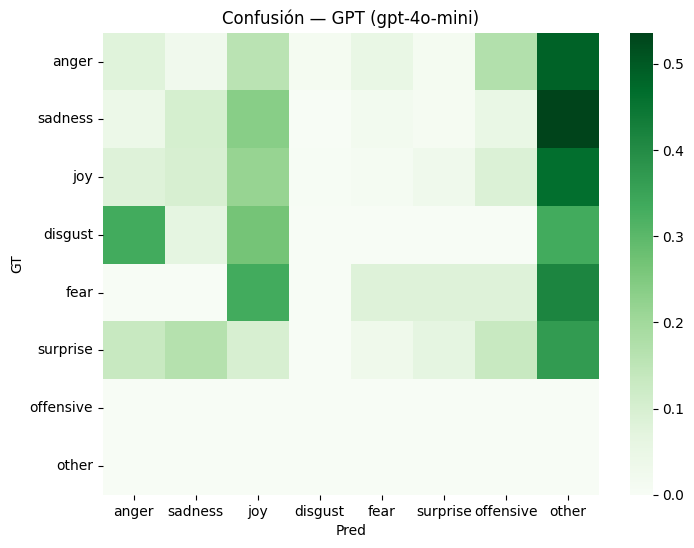

Accuracy: 0.1400 | Macro-F1: 0.0931

Top eventos por accuracy:
 event
WorldBookDay       0.196429
SpainElection      0.173913
ChampionsLeague    0.147059
LaLiga             0.147059
NotreDame          0.130435
Venezuela          0.115385
GameOfThrones      0.112903
GretaThunberg      0.083333
Name: ok, dtype: float64


GPT gpt-4o-mini:   0%|          | 0/400 [00:00<?, ?it/s]


### Reporte por clase
              precision    recall  f1-score   support

       anger      0.231     0.182     0.203        33
     sadness      0.778     0.583     0.667        48
         joy      0.908     0.493     0.639       201
     disgust      0.500     0.026     0.049        78
        fear      1.000     0.235     0.381        17
    surprise      0.364     0.174     0.235        23
   offensive      0.000     0.000     0.000         0
       other      0.000     0.000     0.000         0

    accuracy                          0.357       400
   macro avg      0.473     0.212     0.272       400
weighted avg      0.730     0.357     0.457       400



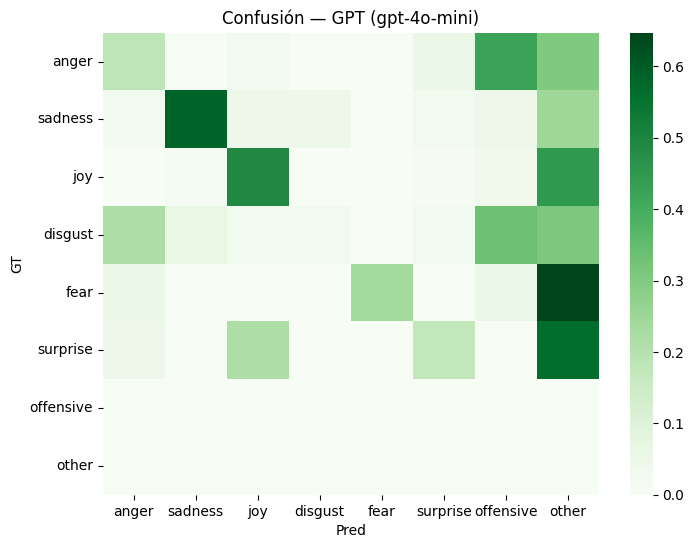

Accuracy: 0.3575 | Macro-F1: 0.2717

Top eventos por accuracy:
 event
LaLiga             0.611111
GameOfThrones      0.571429
NotreDame          0.402597
ChampionsLeague    0.371429
WorldBookDay       0.310345
GretaThunberg      0.268293
SpainElection      0.200000
Venezuela          0.081967
Name: ok, dtype: float64


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import seaborn as sns, matplotlib.pyplot as plt
from tqdm.auto import tqdm
import numpy as np, pandas as pd, time

def eval_gpt(test_df, sample_size=400, model="gpt-4o-mini", fewshot=True, sleep_s=0.0):
    sub = test_df.sample(n=min(sample_size, len(test_df)), random_state=2025).reset_index(drop=True)
    preds = []
    for t in tqdm(sub['text'], total=len(sub), desc=f"GPT {model}"):
        try:
            preds.append(gpt_label(t, model=model, fewshot=fewshot))
        except Exception:
            time.sleep(1.0)
            preds.append(gpt_label(t, model=model, fewshot=fewshot))
        if sleep_s>0: time.sleep(sleep_s)

    print("\n### Reporte por clase")
    print(classification_report(sub['label'], preds, labels=ALL_LABELS, digits=3))

    cm = confusion_matrix(sub['label'], preds, labels=ALL_LABELS, normalize='true')
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=False, cmap='Greens', xticklabels=ALL_LABELS, yticklabels=ALL_LABELS)
    plt.title(f'Confusión — GPT ({model})'); plt.xlabel('Pred'); plt.ylabel('GT'); plt.show()

    acc = accuracy_score(sub['label'], preds)
    mf1 = f1_score(sub['label'], preds, average='macro')
    print(f"Accuracy: {acc:.4f} | Macro-F1: {mf1:.4f}")

    # análisis por evento (si hay columna 'event')
    if 'event' in sub.columns and sub['event'].notna().any():
        tmp = sub.copy(); tmp['pred'] = preds
        ev = (tmp.assign(ok=(tmp['pred']==tmp['label']))
                .groupby('event')['ok'].mean().sort_values(ascending=False))
        print("\nTop eventos por accuracy:\n", ev.head(10))
    return sub, preds

# Corre en español e inglés (ajusta sample_size si quieres)
sub_es_gpt, preds_es_gpt = eval_gpt(test_es, sample_size=400, model="gpt-4o-mini", fewshot=True)
sub_en_gpt, preds_en_gpt = eval_gpt(test_en, sample_size=400, model="gpt-4o-mini", fewshot=True)



In [ ]:
def summarize(name, y_true, y_pred):
    return {
        "model": name,
        "accuracy": accuracy_score(y_true, y_pred),
        "macro_f1": f1_score(y_true, y_pred, average="macro")
    }

rows = []
rows.append(summarize("SVM es", test_es['label'], pred_es_svm))
rows.append(summarize("SVM en", test_en['label'], pred_en_svm))
rows.append(summarize("XLM-R es", test_es['label'], [ALL_LABELS[i] for i in preds_es_xlmr]))
rows.append(summarize("XLM-R en", test_en['label'], [ALL_LABELS[i] for i in preds_en_xlmr]))
rows.append(summarize("GPT-4o-mini es (subset)", sub_es_gpt['label'], preds_es_gpt))
rows.append(summarize("GPT-4o-mini en (subset)", sub_en_gpt['label'], preds_en_gpt))

res_table = pd.DataFrame(rows).sort_values("macro_f1", ascending=False).reset_index(drop=True)
display(res_table.style.format({"accuracy":"{:.3f}","macro_f1":"{:.3f}"}))


,model,accuracy,macro_f1
0,SVM en,0.645,0.391
1,XLM-R en,0.698,0.376
2,GPT-4o-mini en (subset),0.357,0.272
3,XLM-R es,0.358,0.182
4,SVM es,0.353,0.177
5,GPT-4o-mini es (subset),0.140,0.093


#EXPLICACION

XLM-R en (0.698 acc, 0.376 macro-F1) > SVM en (0.645, 0.391):

* XLM-R acierta más en total, pero su macro-F1 es similar/peor → probablemente concentra los aciertos en clases mayoritarias (p. ej. other/offensive) y falla en minoritarias (bajo F1 promedio).




Español (es) sale mucho peor (≈0.35 acc y macro-F1 <0.20):
* Señal de que el modelo no está capturando bien el español o que hay desbalance fuerte/preprocesamiento insuficiente en ES (links/hashtags/acentos/emojis). Revisa que la normalización de etiquetas y la carga de splits ES estén correctas.

GPT-4o-mini (subset): en en (0.357, 0.272) y es (0.140, 0.093) es flojo porque:

* Es zero/few-shot (sin fine-tuning).

* Solo evaluaste un subset (muestras limitadas).

* El prompt puede necesitar ajustes (forzar salida exacta, ejemplos por clase, aclarar idioma).